In [1]:
import json
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Analyzing Rent Prices vs. Taxi Trips

In [189]:
# taxi id - zillow id mapping
tz_map = json.load(open('./taxi_zillow_mapping.json'))

# Group zillow and taxi data according to composite ID.
taxi_to_cluster = {}
zillow_to_cluster = {}
for cluster in tz_map:
    for t in cluster['taxi_ids']:
        assert t not in taxi_to_cluster
        taxi_to_cluster[t] = cluster['id']
    for z in cluster['zillow_ids']:
        assert z not in zillow_to_cluster
        zillow_to_cluster[z] = cluster['id']
        
tz_map[4:6]

[{u'id': 5,
  u'name': u'Prospect Park',
  u'taxi_ids': [190],
  u'zillow_ids': [403161]},
 {u'id': 6,
  u'name': u'Brownsville',
  u'taxi_ids': [35],
  u'zillow_ids': [193526]}]

In [154]:
from datetime import date

In [214]:
def get_taxis(weekend_only=False,
              day_normalized=True,
              add_green=True,
              event='DO'):
    # Load the yellow taxi analysis
    yellow = pd.read_csv('yellow_daily.csv', index_col=None, header=None)
    green = pd.read_csv('green_daily.csv', index_col=None, header=None)
    yellow.columns = ['location_id', 'event', 'year', 'month', 'day',
                     'passengers', 'distance', 'fare', 'count']
    green.columns = yellow.columns[:]
    
    if add_green:
        combined = pd.concat([yellow, green], axis=0, ignore_index=True)
        combined = combined.groupby(['location_id', 'event', 'year', 'month', 'day'])\
            .sum().reset_index()
        yellow = combined

    is_weekend = []
    SATURDAY = 5
    for y in yellow.itertuples():
        d = date(y.year, y.month, y.day)
        is_weekend.append(d.weekday() >= SATURDAY)
        
    if weekend_only:
        yellow = yellow[is_weekend]

    # What are daily stats for the entire city?
    yellow_citywide = yellow.drop(['location_id'], axis=1)\
        .groupby(by=['event', 'year', 'month', 'day'])\
        .sum().reset_index()
    yellow_citywide = yellow_citywide[yellow_citywide['year'] >= 2013]
    cw = yellow_citywide
    cw = cw[cw['event'] == event]
    cw = cw[cw['year'] < 2017]
    cw = cw[cw['year'] >= 2013]
    cw = cw[['year', 'month', 'day', 'count']]
    cw_mean = cw['count'].mean()
    print(len(cw))

    yellow['composite_id'] = yellow['location_id'].map(lambda x: taxi_to_cluster.get(x, -1))
    
    yellow_composite = yellow.drop('location_id', axis=1)\
        .groupby(by=['composite_id', 'event', 'year', 'month', 'day'])\
        .sum().reset_index()
        
    available_cluster_ids = list(yellow['composite_id'].unique())
    by_cluster_map = {}
    for cluster_id in available_cluster_ids:
        # Get taxi dropoffs
        yc = yellow_composite
        taxis = yc[yc['composite_id'] == cluster_id]
        taxis = taxis[taxis['event'] == event]
        taxis = taxis[taxis['year'] < 2017]
        taxis = taxis[taxis['year'] >= 2013]
        taxis = taxis[['year', 'month', 'day', 'count']]
        taxis = pd.merge(taxis, cw, on=['year', 'month', 'day'])

        if day_normalized:
            cy = taxis['count_y']
            taxis['count'] = taxis['count_x'].as_matrix() * cw_mean / cy.as_matrix()
        else:
            taxis['count'] = taxis['count_x']
        taxis = taxis[['year', 'month', 'day', 'count']]
            
        taxis = taxis[['year', 'month', 'count']]
        taxis = taxis.groupby(by=['year', 'month']).mean().reset_index()
        by_cluster_map[cluster_id] = taxis
        
    return yellow_composite, by_cluster_map

In [215]:
yellow = get_taxis(add_green=False)
combined = get_taxis(add_green=True)
combined_no_norm = get_taxis(day_normalized=False)

1461
1461
1461


In [216]:
yellow[1][112]

,year,month,count
0,2013,1,247.471221
1,2013,2,244.121439
2,2013,3,263.757292
3,2013,4,257.361432
4,2013,5,267.881324
5,2013,6,257.432143
6,2013,7,254.560677
7,2013,8,268.388467
8,2013,9,250.562304
9,2013,10,250.178156


# Adjust Zillow Rent Prices With Inflation

In [243]:
def get_zillow(fname='./Neighborhood_MedianRentalPrice_1Bedroom.csv',
              adjust_inflation=True):
    # Load zillow rent prices
    # DL from: http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_1Bedroom.csv
    zillow = pd.read_csv(fname)
    z = zillow
    zillow = zillow[(z['City'] == 'New York') & (z['State'] == 'NY')]
    early_cols = ['{}-{:02}'.format(year, month) for year in [2010, 2011, 2012, 2017] for month in range(1,13)]
    early_cols = [c for c in early_cols if c in zillow.columns]
    zillow = zillow.drop(early_cols, axis=1)

    # Read inflation data
    inflation = pd.read_csv('cpi_inflation.csv', index_col='Year')
    
    # Create an array with zillow prices adjusted by inflation.
    zillow_inf_adjust = zillow.copy()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    standard = inflation.ix[2016]['Dec'] # Rescale values to this time.
    for year in range(2013, 2017):
        for month in range(1, 13):
            colname = '{}-{:02}'.format(year, month)
            col = zillow_inf_adjust[colname]
            col = standard / inflation.ix[year][months[month - 1]] * col
            zillow_inf_adjust[colname] = col
            
    if not adjust_inflation:
        zillow_inf_adjust = zillow # Revert
    
    # What is the Zillow Neighborhood ID?
    zillow_shape = json.load(open('ZillowNeighborhoods-NY_mapshaper.json'))
    # Need a mapping from zillow region name to zillow ID
    z_name_to_id = {}
    for z in zillow_shape['features']:
        prop = z['properties']
        zid = int(prop['RegionID'])
        z_name_to_id[prop['Name']] = prop['RegionID']

    region_ids = []
    for z in zillow_inf_adjust.itertuples():
        regid = z_name_to_id[z.RegionName]
        region_ids.append(regid)
#        print(z.RegionName, regid)
    zillow_inf_adjust['RegionId'] = region_ids
        
    zillow_inf_adjust['CompositeId'] =\
        zillow_inf_adjust['RegionId'].map(lambda x: zillow_to_cluster.get(int(x), -1))
        
    z = zillow_inf_adjust
    zillow_composite = z.drop([
            'RegionName', 'City',
            'State', 'Metro', 'CountyName',
            'SizeRank', 'RegionId'], axis=1)\
        .groupby(by=['CompositeId'])\
        .mean().reset_index()
        
    zillow_t = zillow_composite.set_index('CompositeId').T
    by_cluster = {}
    for cluster_id in list(zillow_t.columns):
        col = zillow_t[cluster_id]
        pairs = zip(col.index, col)
        rows = []
        for date, price in pairs:
            year = int(date[:4])
            month = int(date[-2:])
            rows.append((year, month, price))
        df = pd.DataFrame(rows, columns=['year', 'month', 'price'])
        by_cluster[cluster_id] = df
        
    return zillow_composite, by_cluster

In [244]:
zillow_composite = get_zillow()
zillow_no_inflation = get_zillow(adjust_inflation=False)

In [245]:
zillow_composite[1][22]

,year,month,price
0,2013,1,1320.266596
1,2013,2,1372.083126
2,2013,3,1343.682474
3,2013,4,1367.687542
4,2013,5,1412.542652
5,2013,6,1416.006686
6,2013,7,1414.606579
7,2013,8,1412.409339
8,2013,9,1404.302825
9,2013,10,1408.287834


# Generate Plots

In [247]:
# What neighborhoods are available?
avail_ids = set(zillow_composite[1].keys()).intersection(set(yellow[1].keys()))
for c in tz_map:
    if c['id'] in avail_ids:
        print(c['name'])

Central Park
Greenpoint
Park Slope
Bayside-Douglaston-Oakland Gardens
East Village
East Elmhurst-Jackson Heights
Long Island City/Hunters Point
East Flatbush
Kew Gardens-Richmond Hill
Kingsbridge Heights-University Heights/Morris Heights
East Harlem
Flatlands-Midwood
Cobble Hill
Bay Ridge
Concourse
Forest Hills-Forest Park/Highland Park-Glendale
Hamilton Heights-Manhattanville
Pelham Bay-Schuylerville/Edgewater Park
Boerum Hill-Carroll Gardens-Gowanus
TriBeCa/Civic Center
Brooklyn Heights
Inwood
Chinatown-Lower East Side
Elmhurst
Crown Heights
Harlem
Fort Greene
Washington Heights
Briarwood/Jamaica Hills
Midtown
East New York
Norwood
Windsor Terrace
Bronxdale-Co-Op City-Eastchester-Williamsbridge/Olinville
Woodside
Bushwick
Jamaica
Rego Park
Borough Park-Ocean Parkway South
Sunset Park-Greenwood
Erasmus-Flatbush/Ditmas Park
Flushing-Murray Hill-Auburndale
Clinton Hill-Bedford Stuyvesant
Pelham Parkway-Van Nest/Morris Park
Kew Gardens Hills
Prospect Heights
Garment District-Flatiron Dis

In [248]:
name = 'Sunnyside'
# find cluster matching that name.
cluster = None
for c in tz_map:
    if name.lower() in c['name'].lower():
        cluster = c
        break
print(cluster)
name = cluster['name']

{u'zillow_ids': [270802, 275620], u'id': 111, u'name': u'Sunnyside', u'taxi_ids': [226]}


In [257]:
cid = cluster['id']
# Get taxi data
taxi = yellow[1][cid]
zillow = zillow_composite[1][cid]
join = pd.merge(taxi, zillow, on=['year', 'month'])
join = join.set_index(['year', 'month'])
join

count        price
year month                          
2013 1      1228.234390  1760.355461
     2      1168.895255  1811.149727
     3      1240.145035  1809.858026
     4      1125.450680  1805.347556
     5      1189.837663  1799.764769
     6      1214.563635  1846.254872
     7      1199.277559  1904.278087
     8      1225.173581  1901.320264
     9      1174.027951  1897.706520
     10     1155.316864  1895.772085
     11     1187.188206  1891.270950
     12     1255.383038  1887.103377
2014 1      1135.926323  1879.580993
     2      1142.212003  1928.298311
     3      1182.105625  1920.363987
     4      1127.012537  1974.183761
     5      1178.005684  1993.910216
     6      1206.467226  1991.831551
     7      1171.124246  1987.414922
     8      1179.464975  1984.959320
     9      1162.917726  1982.602903
     10     1144.923640  1978.893170
     11     1221.265249  1975.625947
     12     1223.396654  1971.833379
2015 1      1181.149973  1969.031897
     2      1238.665883  1964.832095
     3      1300.090567  1962.415358
     4      1178.594525  1957.574914
     5      1182.474189  1956.634427
     6      1161.070497  1978.695199
     7      1183.614416  1975.007137
     8      1214.442749  1971.506275
     9      1195.097580  1967.400568
     10     1148.920132  2015.785585
     11     1191.704093  1960.383184
     12     1204.956141  2009.343204
2016 1      1205.489449  2005.595800
     2      1095.022038  2047.134060
     3      1195.456717  1998.217190
     4      1233.897747  2042.150602
     5      1172.330707  1936.737760
     6      1156.606799  1932.442013
     7      1189.307363  1927.778142
     8      1164.428485  1972.399144
     9      1150.452460  2066.869440
     10     1132.316121  2060.284114
     11     1116.811311  2005.418167
     12     1186.654726  1875.000000

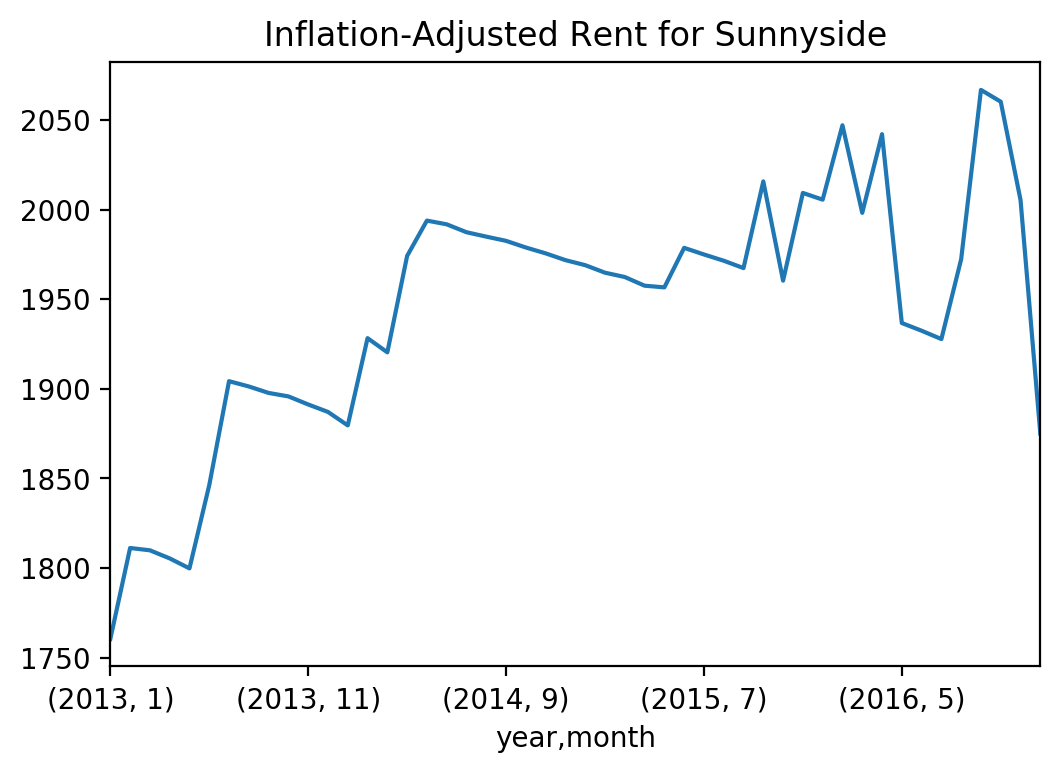

In [258]:
# Get one of the areas' columns
plt.figure()
ax = join['price'].plot(ax=plt.gca(), title='Inflation-Adjusted Rent for ' + name, legend=False)
#ax = taxis.plot(ax=plt.gca(), legend=False)

plt.show()

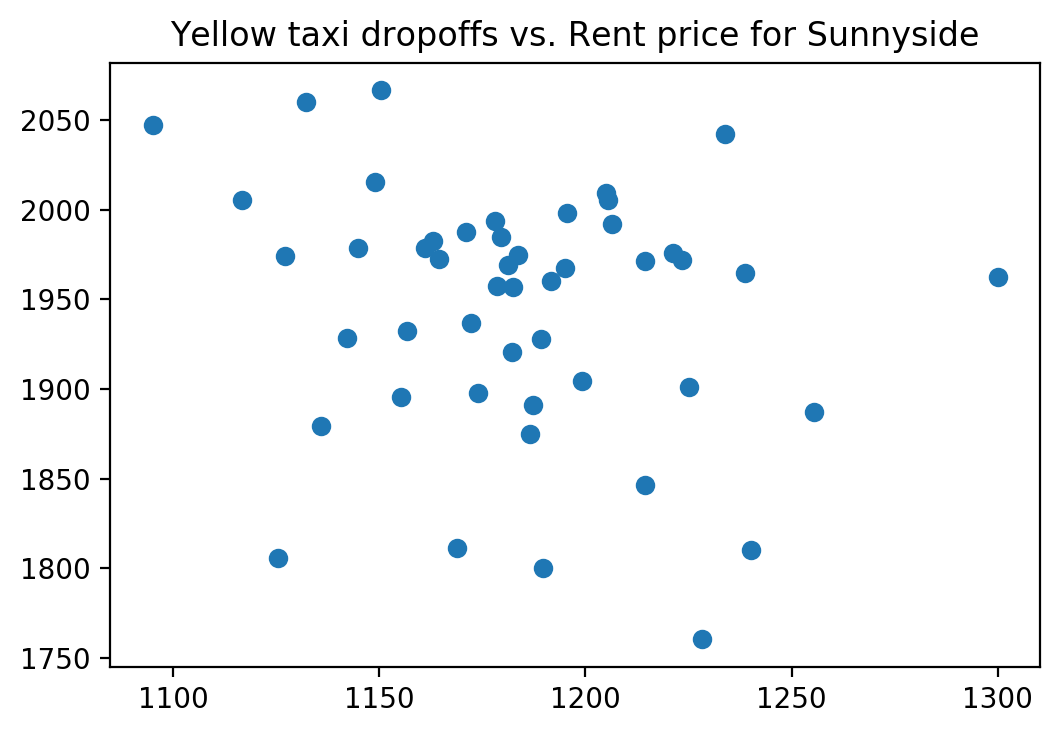

-0.206713442514


In [260]:
plt.figure()
plt.scatter(join['count'], join['price'])
plt.title('Yellow taxi dropoffs vs. Rent price for ' + name)
plt.show()
print(join['count'].corr(join['price']))

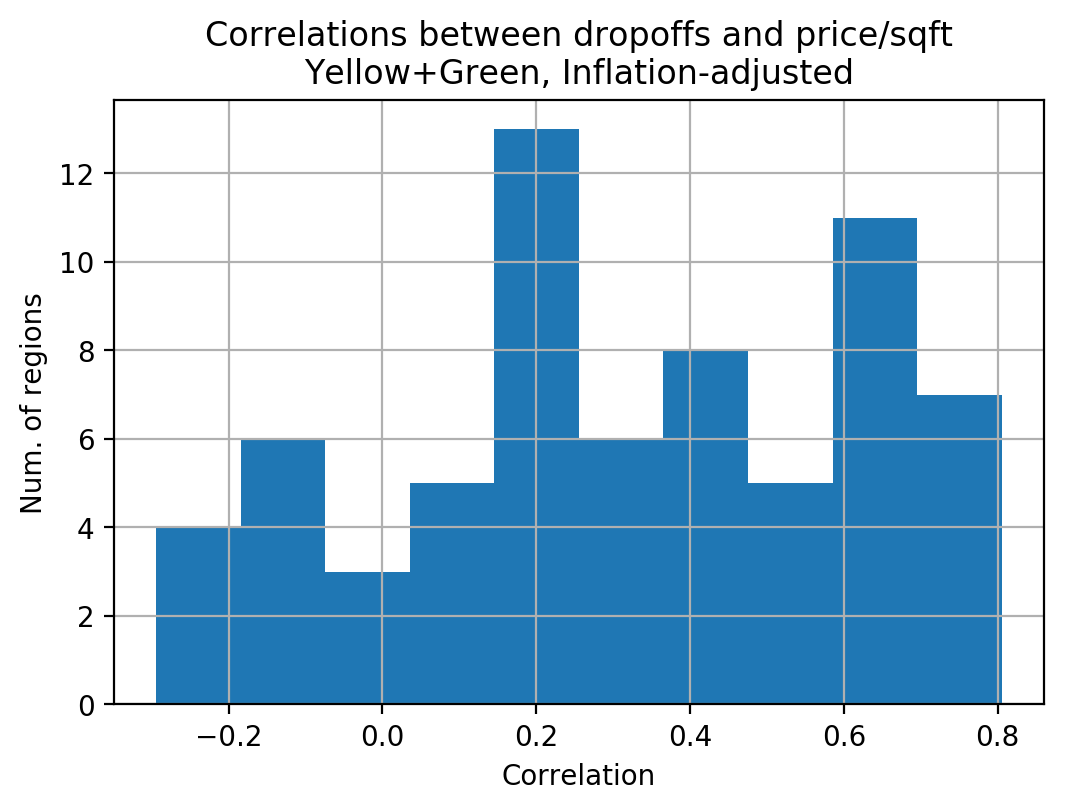

In [275]:
# What neighborhoods are available?
avail_ids = set(zillow_composite[1].keys()).intersection(set(yellow[1].keys()))
corr = {}
for cid in avail_ids:
    # Get taxi data
    taxi = yellow[1][cid]
    zillow = zillow_composite[1][cid]
    join = pd.merge(taxi, zillow, on=['year', 'month'])
    join = join.set_index(['year', 'month'])
    corr_cid = join['count'].corr(join['price'])
    if cid >= 0:
        corr[cid] = corr_cid

corr = pd.Series(corr)

plt.figure()
corr.hist(ax=plt.gca())
plt.title('Correlations between dropoffs and price/sqft\n'
          'Yellow+Green, Inflation-adjusted')
plt.ylabel('Num. of regions')
plt.xlabel('Correlation')
plt.show()

In [ ]:
# If 